In [1]:
from similarity_functions import get_similar_images
import pandas as pd

Table 'image_database_T7_1' created successfully.


/Users/nick/opt/anaconda3/envs/big_data/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/nick/opt/anaconda3/envs/big_data/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <9B280146-BBD7-3F77-9873-F9740F2A5329> /Users/nick/opt/anaconda3/envs/big_data/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <350C3DCC-77CE-3CC1-B749-5ADAF64BD38A> /Users/nick/opt/anaconda3/envs/big_data/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# Database with the image metadata
database_path = '/Volumes/T7 Shield 1/Uni/4. Semester/Big Data Engineering/image_database.db'
table_name = 'image_database_T7_1'

# load color embeddings
color_embeddings = pd.read_pickle("color_vectors.pkl")

# load image embeddings
image_embeddings = pd.read_pickle("image_vectors.pkl")

### Image Similarity Search based on the content

/Users/nick/opt/anaconda3/envs/big_data/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nick/opt/anaconda3/envs/big_data/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
[W NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


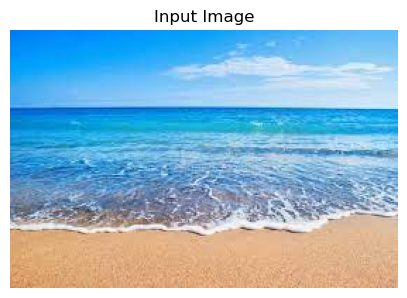

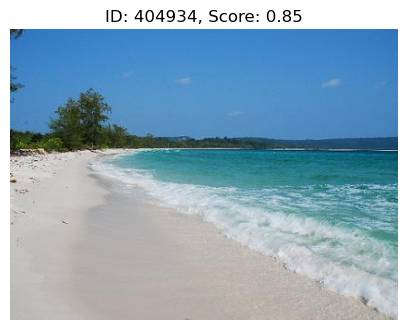

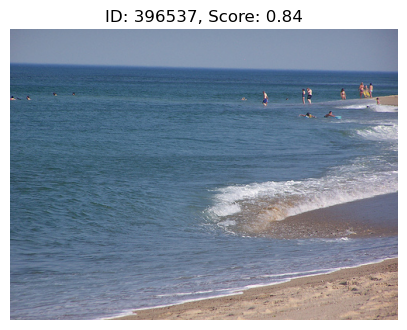

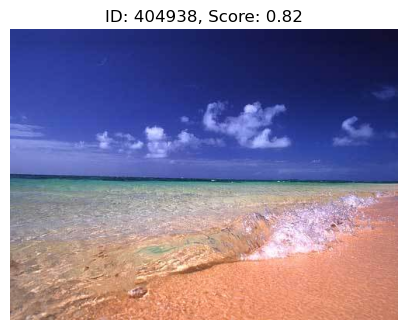

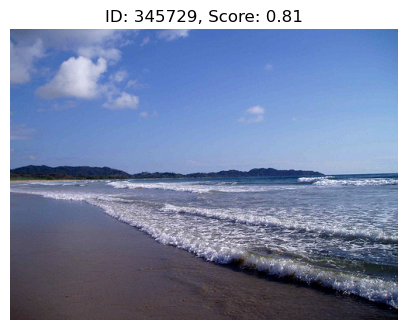

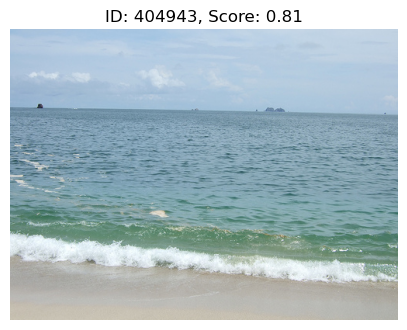

In [4]:
image_path = '/Users/nick/Downloads/beach.jpeg'
mode = 'content'
number_of_pictures = 5

get_similar_images(image_path, database_path, table_name, mode, image_embeddings, number_of_pictures)

### Image Similarity Search based on the Colors

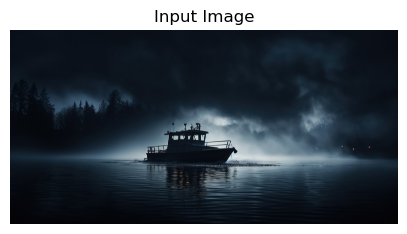

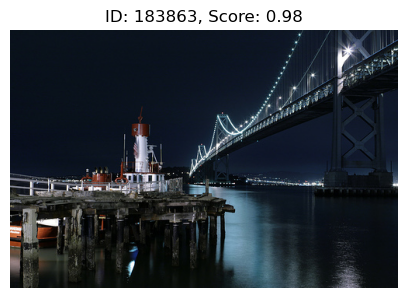

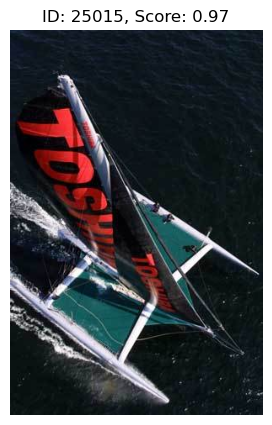

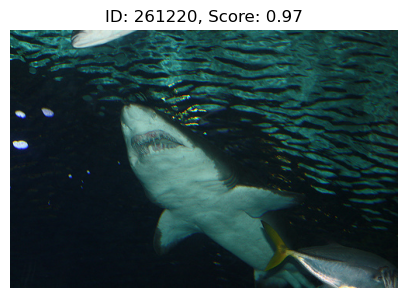

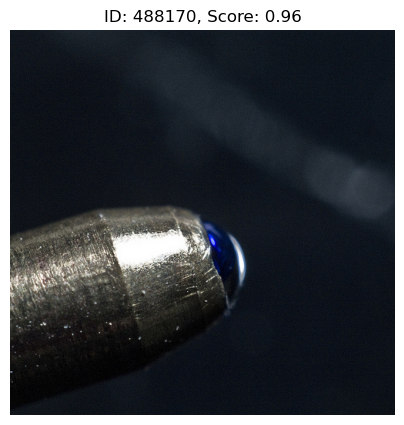

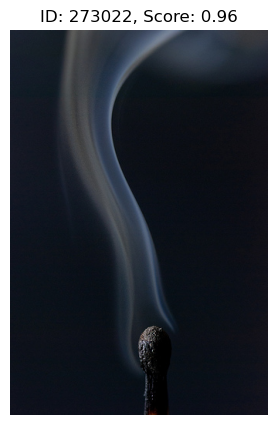

In [6]:
image_path = '/Users/nick/Documents/dark_boat.jpg'
mode = 'color'
number_of_pictures = 5

get_similar_images(image_path, database_path, table_name, mode, color_embeddings, number_of_pictures)